/bin/bash: line 1: kaggle: command not found


In [8]:
!pip install numpy==1.26.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 2.7 MB/s eta 0:00:00m eta 0:00:010:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt


/home/alie/PMLDL-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize([200, 200]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path)
        
        # Extract target value from filename (assuming format: 'image_name_target.jpg')
        target = int(self.image_files[idx].split('_')[0])
        
        if self.transform:
            image = self.transform(image)

        return image, target

# Example usage
# transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
dataset = CustomImageDataset('../data/UTKFace', transform=transform)


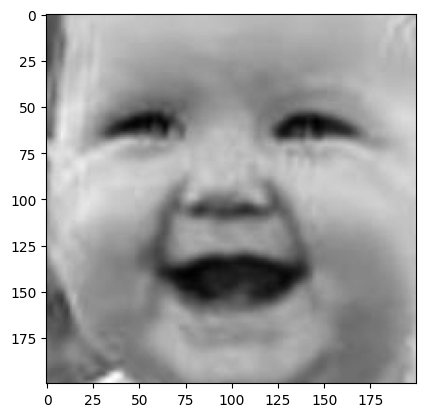

In [4]:
img = dataset.__getitem__(1)
def display(img):
    plt.imshow(img)
    plt.set_cmap('gray')
    plt.show()

display(img[0].squeeze())

In [5]:
img[0].shape

torch.Size([1, 200, 200])

In [6]:
batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [46]:
class AgeDetectionCNN(nn.Module):
    def __init__(self):
        super(AgeDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(self.dropout(torch.relu(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout(torch.relu(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout(torch.relu(self.bn3(self.conv3(x)))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))

        x = self.gap(x)
        x = x.view(-1, 256)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)  # No dropout here as it's the output layer
        
        return x


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AgeDetectionCNN().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
criterion = nn.MSELoss()


In [49]:
from tqdm import tqdm  # Import tqdm for the progress bar

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False,
                                bar_format="{l_bar}{bar:0}{r_bar}{bar:5b}")
        
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate number of correct predictions based on a tolerance of 5 years for regression task
            batch_correct_predictions = torch.sum(torch.abs(outputs.squeeze() - labels) < 5).item()
            correct_predictions += batch_correct_predictions

            batch_acc = batch_correct_predictions / images.size(0)

            # Update tqdm with batch loss and accuracy
            train_loader_tqdm.set_postfix(acc=batch_acc)

        # Compute epoch loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        # Add tqdm for tracking progress of validation
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1} Val", leave=False)
        
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                # Calculate validation accuracy using a tolerance of 5 for regression task
                val_correct += torch.sum(torch.abs(outputs.squeeze() - labels) < 5).item()

                # Update tqdm with validation loss and accuracy for each batch
                batch_val_acc = torch.sum(torch.abs(outputs.squeeze() - labels) < 5).item() / images.size(0)
                val_loader_tqdm.set_postfix(val_loss=loss.item(), val_accuracy=batch_val_acc)

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.00009)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20, Loss: 2.2418, Accuracy: 0.5137


Validation Loss: 2.7618, Validation Accuracy: 0.5605


Epoch 2/20, Loss: 2.2466, Accuracy: 0.5108


Validation Loss: 2.7430, Validation Accuracy: 0.5704


Epoch 3/20, Loss: 2.2215, Accuracy: 0.5147


Validation Loss: 3.2862, Validation Accuracy: 0.5373


Epoch 4/20, Loss: 2.2580, Accuracy: 0.5086


Validation Loss: 2.9808, Validation Accuracy: 0.5607


Epoch 5/20, Loss: 2.2087, Accuracy: 0.5170


Validation Loss: 2.9661, Validation Accuracy: 0.5614


Epoch 6/20, Loss: 2.1738, Accuracy: 0.5174


Validation Loss: 2.8241, Validation Accuracy: 0.5692


Epoch 7/20, Loss: 2.2083, Accuracy: 0.5181


Validation Loss: 2.7950, Validation Accuracy: 0.5709


Epoch 8/20, Loss: 2.2395, Accuracy: 0.5157


Validation Loss: 2.7820, Validation Accuracy: 0.5687


Epoch 9/20, Loss: 2.1996, Accuracy: 0.5159


Validation Loss: 3.0566, Validation Accuracy: 0.5538


Epoch 10/20, Loss: 2.1428, Accuracy: 0.5235


Validation Loss: 2.9183, Validation Accuracy: 0.5700


Epoch 11/20, Loss: 2.2233, Accuracy: 0.5152


Validation Loss: 2.9509, Validation Accuracy: 0.5633


Epoch 12:  65%|| 386/593 [03:41<02:06,  1.64it/s, acc=0.4

In [56]:
torch.save(model.state_dict(), 'age_pred_.pth')